# Carregar modelo

In [110]:
from keras.models import load_model

backtestDays = 1
daysCandles = 114
modelo = load_model('models/CustomModel1.h5')
modelo.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 501, 6, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 478, 2, 100)       12100     
                                                                 
 max_pooling2d (MaxPooling2  (None, 239, 1, 100)       0         
 D)                                                              
                                                                 
 reshape (Reshape)           (None, 239, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 216, 200)          480200    
                                                                 
 max_pooling1d (MaxPooling1  (None, 108, 200)          0         
 D)                                                          

In [111]:
import os
modelosPaths = os.listdir('models')
modelosPaths

['CNNmodel.h5',
 'CNNmodel4.h5',
 'CustomModel1.h5',
 'CustomModel2.h5',
 'TransferLearningmodel6.h5']

# Teste Finaceiro

In [112]:
from tqdm import tqdm
import numpy as np
from obterDados import obterSimboloPosicao, obterSimboloData

data = []
for i in tqdm(range(backtestDays*daysCandles, -1, -1)):
    histM5 = obterSimboloPosicao('WDO$N', n=300, delayCandles=i)
    histM5['minute'] = histM5.index.minute
    histM5['hour'] = histM5.index.hour
    histM5['day_of_week'] = histM5.index.day_of_week
    histM5['day'] = histM5.index.day
    histM5NP = histM5.to_numpy()
    hist = np.zeros((501, 6))
    hist[0, -4:] = histM5NP[-1][-4:]
    hist[1:301] = histM5NP[:, :6]
    histD1 = obterSimboloData(histM5.index[-1])
    histD1NP = histD1.to_numpy()
    hist[301:] = histD1NP
    vmax = hist[1:301, :4].max()
    vmin = hist[1:301, :4].min()
    hist[1:301, :4] = (hist[1:301, :4] - vmin) / (vmax - vmin)
    vmax = hist[1:301, 4].max()
    vmin = hist[1:301, 4].min()
    hist[1:301, 4] = (hist[1:301, 4] - vmin) / (vmax - vmin)
    vmax = hist[1:301, 5].max()
    vmin = hist[1:301, 5].min()
    hist[1:301, 5] = (hist[1:301, 5] - vmin) / (vmax - vmin)
    vmax = hist[301:, :4].max()
    vmin = hist[301:, :4].min()
    hist[301:, :4] = (hist[301:, :4] - vmin) / (vmax - vmin)
    vmax = hist[301:, 4].max()
    vmin = hist[301:, 4].min()
    hist[301:, 4] = (hist[301:, 4] - vmin) / (vmax - vmin)
    vmax = hist[301:, 5].max()
    vmin = hist[301:, 5].min()
    hist[301:, 5] = (hist[301:, 5] - vmin) / (vmax - vmin)
    hist[0, 2] /= 60
    hist[0, 3] /= 24
    hist[0, 4] /= 4
    hist[0, 5] /= 31
    lastPrice = histM5['close'].iloc[-1]
    data.append([hist, lastPrice])

100%|██████████| 115/115 [00:01<00:00, 82.09it/s]


In [113]:
resultados = []

for modeloPath in modelosPaths:
    modelo = load_model('models/' + modeloPath)
    target = 30
    stop = 10
    timeLimit = 36
    total = 0
    long = False
    short = False
    position = 0
    candle = -1
    buys_and_sells = []
    totalHistory = []
    for i in tqdm(range(backtestDays*daysCandles, -1, -1)):
        hist = data[-(i+1)][0]
        priceNow = data[-(i+1)][1]
        totalHistory.append(total)
        if long:
            if priceNow >= position + target:
                total += priceNow - position
                long = False
            if priceNow <= position - stop:
                total += priceNow - position
                long = False
            if candle >= i + timeLimit:
                total += priceNow - position
                long = False
            if not long:
                buys_and_sells.append([i, 'Close', priceNow])
            continue
        if short:
            if priceNow <= position - target:
                total += position - priceNow
                short = False
            if priceNow >= position + stop:
                total += position - priceNow
                short = False
            if candle >= i + timeLimit:
                total += position - priceNow
                short = False
            if not short:
                buys_and_sells.append([i, 'Close', priceNow])
            continue
        previsao = np.argmax(modelo.predict(np.array([hist]), verbose=0)[0])
        if previsao == 1 and 8 <= hist[0, 3] * 24 <= 15:
            long = True
            position = priceNow
            candle = i
            buys_and_sells.append([i, 'Buy', priceNow])
        if previsao == 2 and 8 <= hist[0, 3] * 24 <= 15:
            short = True
            position = priceNow
            candle = i
            buys_and_sells.append([i, 'Sell', priceNow])

    print('Modelo:', modeloPath, 'Total:', total)
    resultados.append([modeloPath, total, buys_and_sells, totalHistory])
    # print('Operações: ', dumps(trade_summary, indent=4))

100%|██████████| 115/115 [00:02<00:00, 45.21it/s]


Modelo: CNNmodel.h5 Total: 31.0


100%|██████████| 115/115 [00:02<00:00, 50.18it/s]


Modelo: CNNmodel4.h5 Total: -7.0


100%|██████████| 115/115 [00:00<00:00, 215.69it/s]


Modelo: CustomModel1.h5 Total: -30.5


100%|██████████| 115/115 [00:04<00:00, 26.80it/s]


Modelo: CustomModel2.h5 Total: 30.5


100%|██████████| 115/115 [00:08<00:00, 13.09it/s]

Modelo: TransferLearningmodel6.h5 Total: -36.0


In [114]:
modelIdx = 3

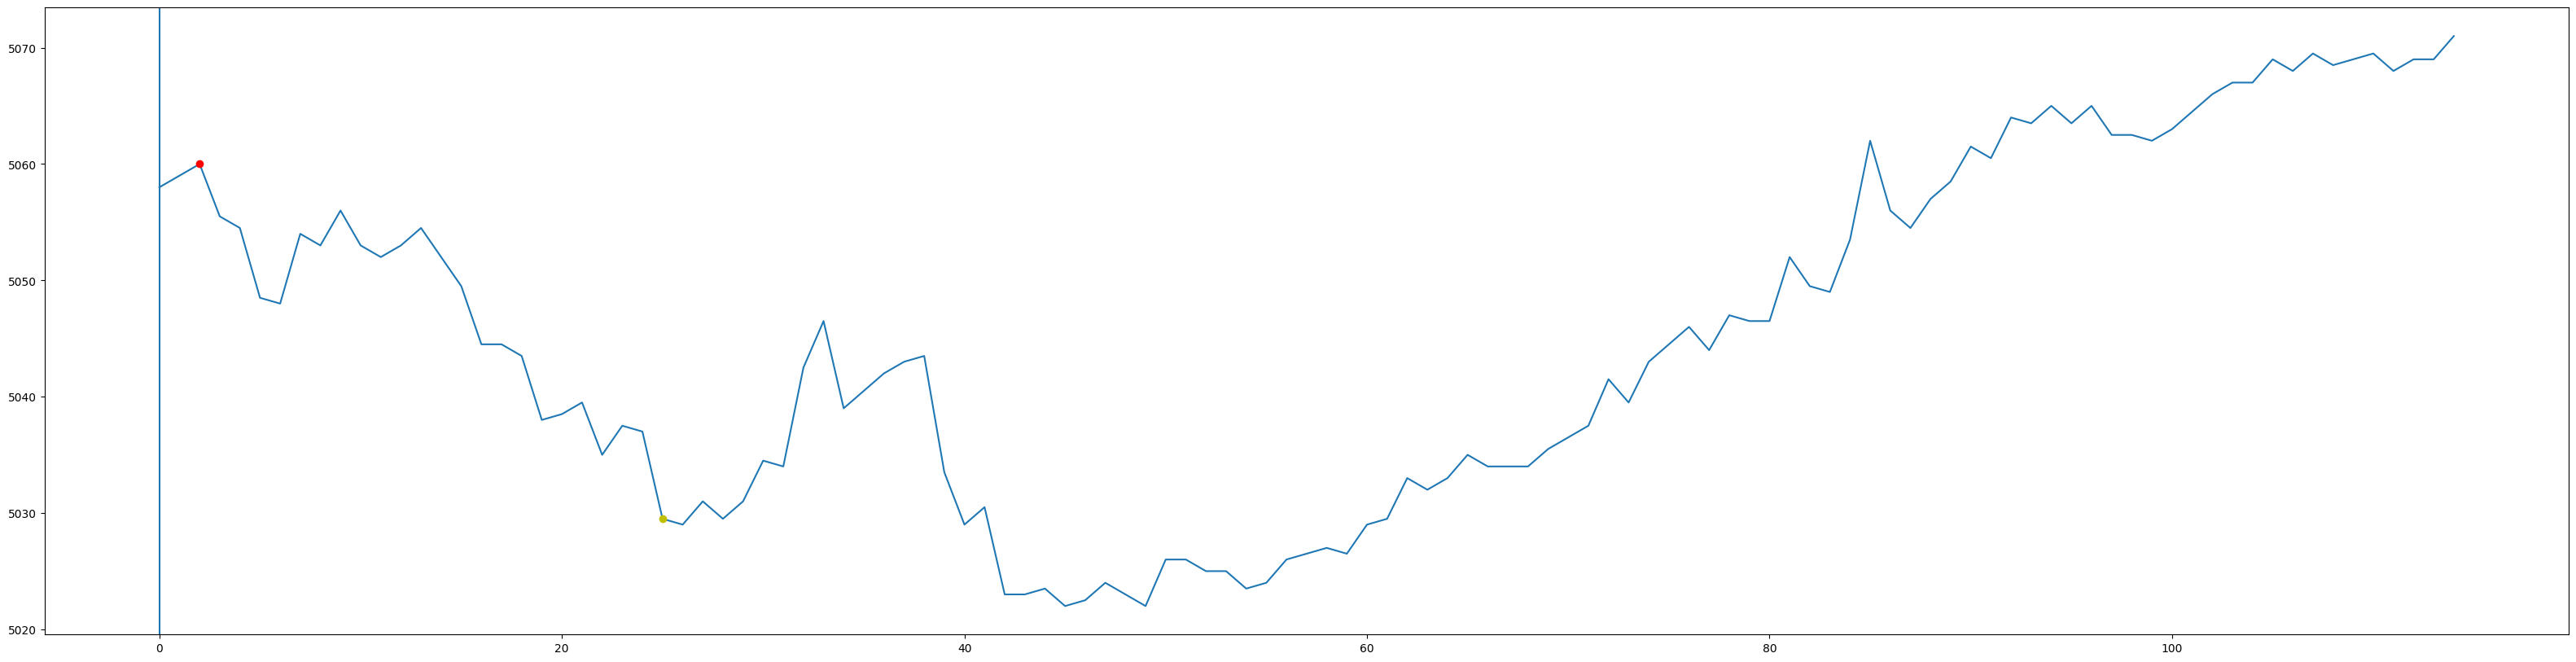

In [115]:
from matplotlib import pyplot as plt

plt.figure(figsize=(40, 10))
priceCloses = obterSimboloPosicao('WDO$N', n=backtestDays*daysCandles+1)['close'].to_numpy()
plt.plot(priceCloses)
for idx, action, price in resultados[modelIdx][2]:
    if action == 'Buy':
        plt.plot(-idx+backtestDays*daysCandles, price, 'o', color='g')
    if action == 'Sell':
        plt.plot(-idx+backtestDays*daysCandles, price, 'o', color='r')
    if action == 'Close':
        plt.plot(-idx+backtestDays*daysCandles, price, 'o', color='y')
for i in range(backtestDays):
    plt.axvline(daysCandles*i)
plt.show()

4/4 [==============================] - 0s 15ms/step


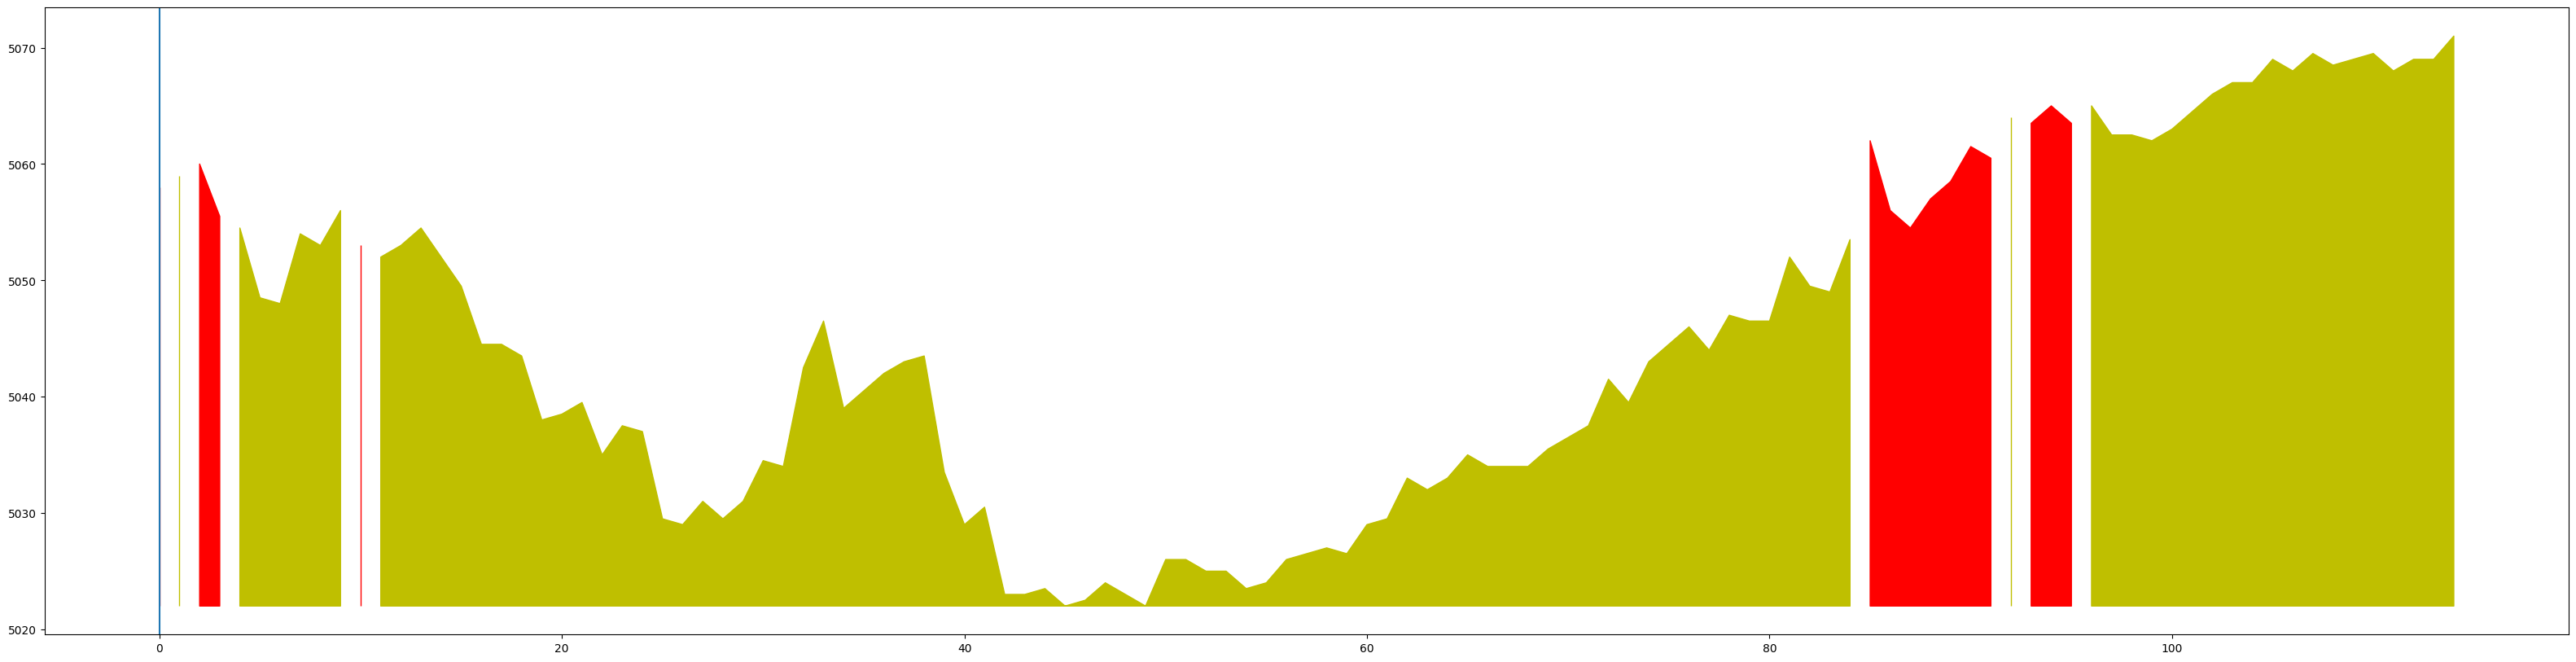

In [116]:
modelo = load_model('models/' + modelosPaths[modelIdx])
inputs = []
for hist, lastPrice in data:
    inputs.append(hist)
previsoes = np.argmax(modelo.predict(np.array(inputs)), axis=1)
expandFactor = 100
previsoesExpanded = np.array([previsoes[i//expandFactor] for i in range((len(previsoes)-1)*expandFactor)])
x = [i for i in range(len(priceCloses))]
fig, ax = plt.subplots(figsize=(40, 10))
minClose = priceCloses.min()
ax.fill_between(x, priceCloses, y2=minClose, where=previsoes==0, color='y')
ax.fill_between(x, priceCloses, y2=minClose, where=previsoes==1, color='g')
ax.fill_between(x, priceCloses, y2=minClose, where=previsoes==2, color='r')
for i in range(backtestDays):
    plt.axvline(daysCandles*i)
plt.show()

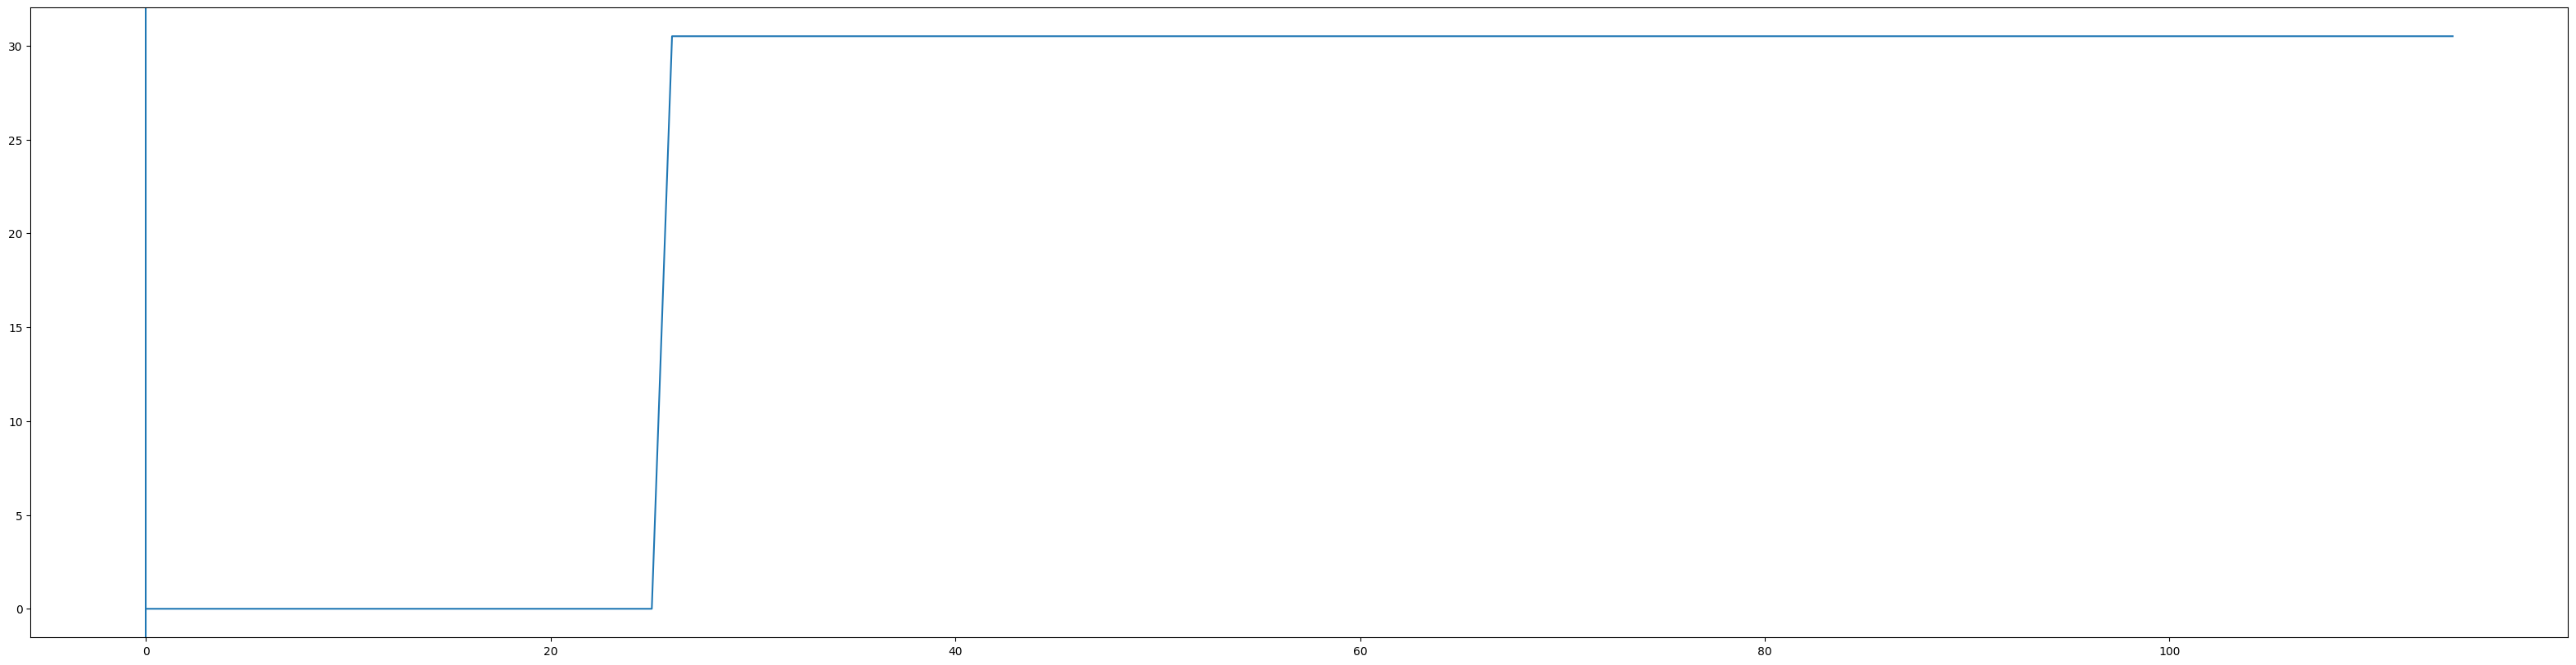

In [117]:
plt.figure(figsize=(40, 10))
plt.plot(resultados[modelIdx][3])
for i in range(backtestDays):
    plt.axvline(daysCandles*i)
plt.show()